# Anomaly Detection Exercise: Credit Card Fraud

In this exercise, we will practice using the Local Outlier Factor and Isolation Forest methods to detect outliers in data sets. We will be looking at data from a selected subset of the data for the ["Credit Card Fraud Detection" Kaggle task](https://www.kaggle.com/mlg-ulb/creditcardfraud/data).

**Questions:**

**Question 1**:

  - Load the data in *creditcard_10k.csv.gz* into a Pandas dataframe *df* and examine the data with *df.describe()*. 
  - Explain the mean and std values for the different features based on the meaning of the features (hint: see the Kaggle task description).

In [1]:
# Basics
import numpy as np
import pandas as pd

# Load

# Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data and describe
df = pd.read_csv('creditcard_10k.csv.gz', compression='gzip')
df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,...,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5966.03,-0.24,0.28,0.91,0.26,-0.05,0.13,-0.07,-0.06,0.80,...,-0.05,-0.15,-0.03,0.02,0.09,0.11,0.01,0.00,63.03,0.00
std,4473.40,1.52,1.31,1.16,1.44,1.18,1.31,1.08,1.26,1.16,...,0.91,0.63,0.49,0.59,0.43,0.56,0.41,0.27,184.49,0.06
min,0.00,-27.67,-34.61,-15.50,-4.66,-32.09,-23.50,-26.55,-23.63,-6.33,...,-11.47,-8.53,-15.14,-2.51,-2.58,-1.34,-7.98,-3.51,0.00,0.00
25%,2072.75,-1.01,-0.21,0.41,-0.61,-0.64,-0.63,-0.54,-0.19,0.07,...,-0.27,-0.55,-0.17,-0.33,-0.16,-0.33,-0.08,-0.02,5.00,0.00
50%,4563.50,-0.37,0.29,0.94,0.22,-0.15,-0.15,-0.06,0.01,0.81,...,-0.12,-0.14,-0.05,0.08,0.12,0.04,-0.00,0.02,15.95,0.00
75%,10233.25,1.15,0.90,1.60,1.13,0.37,0.51,0.48,0.27,1.51,...,0.03,0.25,0.08,0.41,0.36,0.48,0.12,0.08,50.96,0.00
max,15012.00,1.96,8.64,4.10,10.46,34.10,21.39,34.30,5.06,10.39,...,22.59,4.53,13.88,3.20,5.53,3.52,8.25,4.86,7712.43,1.00


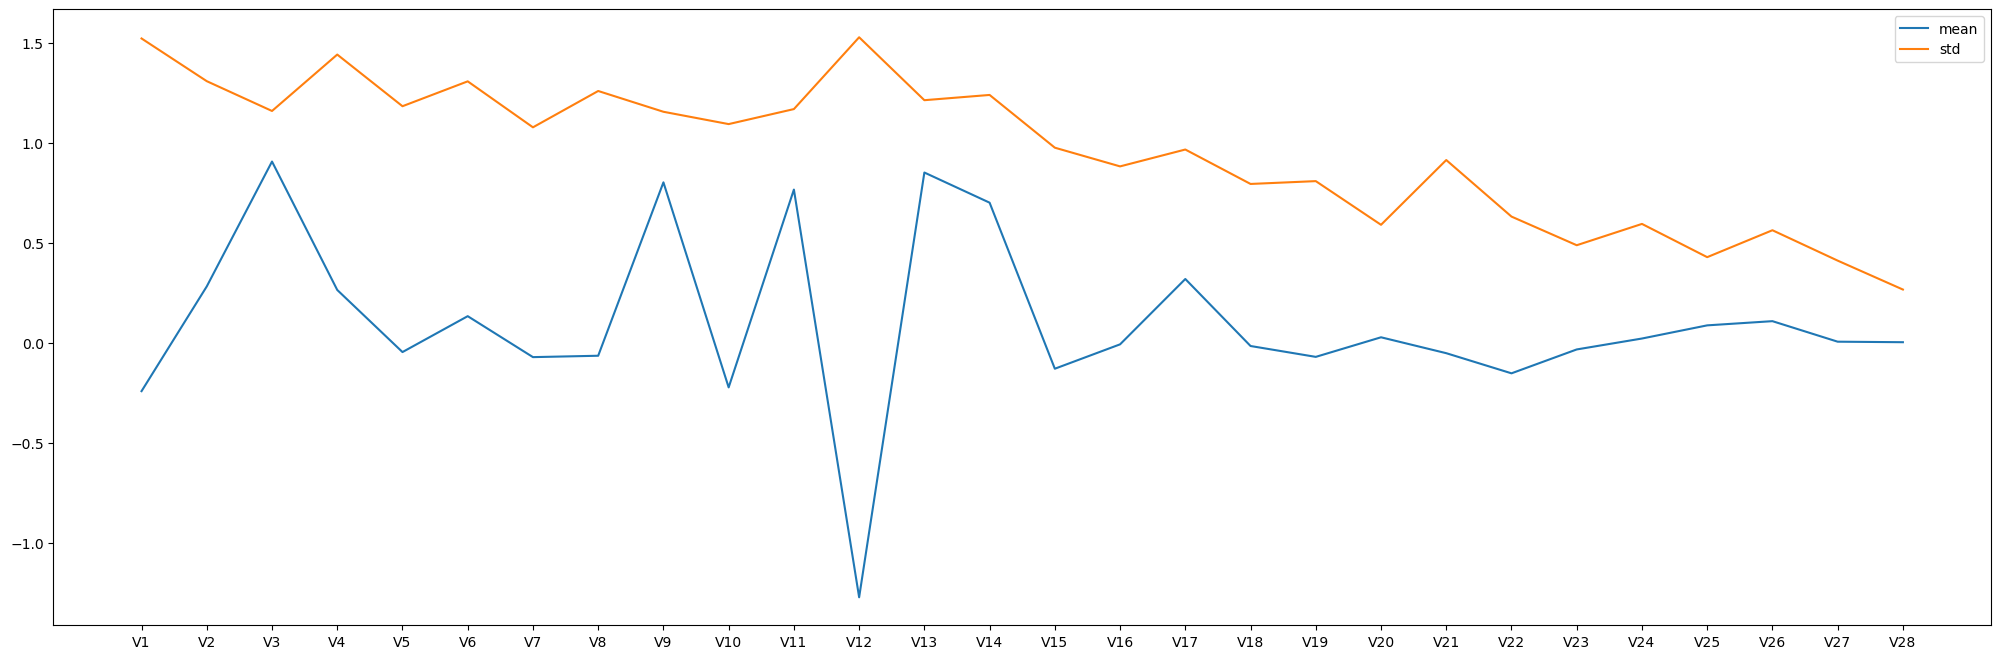

In [3]:
pca_describe = df.describe().loc[['mean', 'std']].transpose().drop(['Time', 'Amount', 'Class'])
plt.figure(figsize=(25, 8))
plt.plot(pca_describe['mean'], label='mean')
plt.plot(pca_describe['std'], label='std')
plt.legend()

There are 2 types of features: PCA components which correspond to V1 to V28 and Time, Amount and Class. Looking at the mean of the PCA components we can see a value close to 0 for most except for V12 with values below -1.

**Question 2**:

Split the data into `X` and `y` (`Class` column of the `df`).  

We will use **unsupervised** Anomaly Detection algorithms to find the outliers, and use the `Class` feature that tells whether the transaction is legitimate or fraudulent only as target labels for **metric** to check how well we were able to recognize the outliers.

In [4]:
target = 'Class'

X = df.drop(target, axis=1)
y = df[target]

**Question 3:**

We will be using and comparing behavior of 2 Anomaly Detection algorithms: Local Outlier Factor and Isolation Forest.   
   - Which one of them is based on distance?  
   - What preprocessing is required for distance-based algorithms?
   - Perform the preprocessing on all features

**Local Outlier Factor (LOF)** is based on distance as it measures the distance of the k nearest neighbors to decide whether a point is an outlier or inlier. Thus, it works best when trying to detect local outliers as it is not context aware. It can be tweaked with a high value of k to detect global outliers.

As it is a distance based algorithm, it requires scaling as an essential part of preprocessing.

**Isolation forest (IF)** is based on isolating points through divisions in the features and then randomly selecting a split value between the max and min of the selected feature. 

Preprocessing:
<br>-Remove unused features
<br>-Scale
<br>-Encode categoricals


In [5]:
X = X.drop(['Time'], axis=1)
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [6]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X.drop(columns=['Amount']))
scaled_X = pd.DataFrame(scaled_X, columns = X.drop(columns=['Amount']).columns)

In [7]:
scaled_X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0.887945,0.798607,0.920126,0.399172,0.479727,0.533732,0.440216,0.827076,0.400270,0.521904,...,0.562466,0.635431,0.336201,0.674112,0.518042,0.451513,0.333961,0.236710,0.499656,0.416749
1,0.974060,0.806445,0.799202,0.337666,0.485745,0.521596,0.434984,0.826602,0.363242,0.511777,...,0.504522,0.620376,0.330109,0.603944,0.525339,0.380306,0.338729,0.301582,0.490874,0.421023
2,0.887994,0.769300,0.881186,0.333144,0.477236,0.563541,0.449285,0.832268,0.287941,0.526495,...,0.281498,0.648282,0.344020,0.711921,0.553185,0.319137,0.277659,0.247011,0.488017,0.412125
3,0.901226,0.796007,0.882196,0.250933,0.484682,0.551215,0.440184,0.836791,0.295573,0.516178,...,0.389974,0.613849,0.333558,0.653245,0.515291,0.234010,0.397995,0.229953,0.495292,0.426607
4,0.894748,0.820588,0.869731,0.334682,0.478686,0.525568,0.446023,0.814208,0.427416,0.547923,...,0.604570,0.642812,0.336461,0.713957,0.517112,0.464526,0.292671,0.379095,0.504947,0.444970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.973617,0.814073,0.794489,0.476169,0.491647,0.519436,0.441642,0.815448,0.406803,0.531351,...,0.433902,0.618984,0.330040,0.609848,0.515550,0.348203,0.400435,0.278889,0.487285,0.420305
9996,0.975295,0.801435,0.842860,0.333586,0.470135,0.499644,0.429982,0.816478,0.480132,0.497475,...,0.481360,0.617909,0.327257,0.596929,0.528933,0.559936,0.309333,0.425956,0.485742,0.420731
9997,0.901042,0.817510,0.909843,0.281041,0.469742,0.509413,0.430080,0.840408,0.474164,0.456010,...,0.452286,0.611222,0.333308,0.642029,0.520949,0.564560,0.272066,0.430173,0.484781,0.423000
9998,0.882213,0.834419,0.867634,0.264184,0.469169,0.497593,0.431296,0.849628,0.435139,0.464377,...,0.428948,0.612364,0.330925,0.604295,0.525316,0.556986,0.284804,0.401680,0.480966,0.420202


In [8]:
standard_scaler = StandardScaler()
scaled_amount = standard_scaler.fit_transform(X[['Amount']])

In [9]:
scaled_amount

array([[ 0.46938016],
       [-0.32708798],
       [ 1.7109446 ],
       ...,
       [-0.31971579],
       [-0.31971579],
       [ 0.52174443]])

In [10]:
scaled_amount.shape

(10000, 1)

In [11]:
scaled_amount_df = pd.DataFrame(scaled_amount, columns = ['Amount'])
scaled_amount_df.head()

,Amount
0,0.469380
1,-0.327088
2,1.710945
3,0.327791
4,0.037727


In [12]:
# Concat V1...V28 dataframe with 'amount' dataframe
frames = [scaled_X, scaled_amount_df]
scaled_X = pd.concat(frames, axis=1)
scaled_X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.887945,0.798607,0.920126,0.399172,0.479727,0.533732,0.440216,0.827076,0.400270,0.521904,...,0.635431,0.336201,0.674112,0.518042,0.451513,0.333961,0.236710,0.499656,0.416749,0.469380
1,0.974060,0.806445,0.799202,0.337666,0.485745,0.521596,0.434984,0.826602,0.363242,0.511777,...,0.620376,0.330109,0.603944,0.525339,0.380306,0.338729,0.301582,0.490874,0.421023,-0.327088
2,0.887994,0.769300,0.881186,0.333144,0.477236,0.563541,0.449285,0.832268,0.287941,0.526495,...,0.648282,0.344020,0.711921,0.553185,0.319137,0.277659,0.247011,0.488017,0.412125,1.710945
3,0.901226,0.796007,0.882196,0.250933,0.484682,0.551215,0.440184,0.836791,0.295573,0.516178,...,0.613849,0.333558,0.653245,0.515291,0.234010,0.397995,0.229953,0.495292,0.426607,0.327791
4,0.894748,0.820588,0.869731,0.334682,0.478686,0.525568,0.446023,0.814208,0.427416,0.547923,...,0.642812,0.336461,0.713957,0.517112,0.464526,0.292671,0.379095,0.504947,0.444970,0.037727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.973617,0.814073,0.794489,0.476169,0.491647,0.519436,0.441642,0.815448,0.406803,0.531351,...,0.618984,0.330040,0.609848,0.515550,0.348203,0.400435,0.278889,0.487285,0.420305,-0.053341
9996,0.975295,0.801435,0.842860,0.333586,0.470135,0.499644,0.429982,0.816478,0.480132,0.497475,...,0.617909,0.327257,0.596929,0.528933,0.559936,0.309333,0.425956,0.485742,0.420731,-0.275645
9997,0.901042,0.817510,0.909843,0.281041,0.469742,0.509413,0.430080,0.840408,0.474164,0.456010,...,0.611222,0.333308,0.642029,0.520949,0.564560,0.272066,0.430173,0.484781,0.423000,-0.319716
9998,0.882213,0.834419,0.867634,0.264184,0.469169,0.497593,0.431296,0.849628,0.435139,0.464377,...,0.612364,0.330925,0.604295,0.525316,0.556986,0.284804,0.401680,0.480966,0.420202,-0.319716


**Question 4:** What percentage of transactions in the dataset are fraudulent using the `Class` feature?

In [13]:
fraudulent_transactions_ratio = (y == 1).mean()
fraudulent_transactions_ratio

0.0038

In [14]:
print(f'Fraudulent Transaction Percentage = {fraudulent_transactions_ratio*100:.2f}%')

Fraudulent Transaction Percentage = 0.38%


**Question 5:**

Use `sklearn.neighbors.LocalOutlierFactor` with default parameters to detect outliers in transaction details.  How many transactions and what percentage of transactions are called fraudulent (outliers) with default parameters of LocalOutlierFactor?

In [15]:
# LOF
lof = LocalOutlierFactor()
outlier_scores = lof.fit_predict(scaled_X)

In [16]:
outliers = (outlier_scores == -1)
print(f'Number of Outliers = {outliers.sum()}')

Number of Outliers = 480


In [17]:
inliers = (outlier_scores == 1)
outliers_ratio = outliers.sum() / len(outlier_scores)
print(f'Fraudulent Transaction Percentage - with LOF (default) = {outliers_ratio*100:.2f}%')

Fraudulent Transaction Percentage - with LOF (default) = 4.80%


**Question 6:**

- Use `sklearn.metrics.confusion_matrix` and `sklearn.metrics.classification_report` to compare the results from unsupervised anomaly detection with LOF of previous question with the target labels. 
- Is the output of LOF with default parameters better than randomly selecting same number of transactions as were chosen by LOF in previous question? Why or why not? (Hint: if we would randomly select X% of observations as outliers, what percentage of real outliers would be chosen?)

In [18]:
y_true = y.values
y_pred = outlier_scores

In [19]:
(y_true == 0).sum()

9962

In [20]:
y_true.min(), y_pred.min()

(0, -1)

In [21]:
y_pred[y_pred ==  1] = 0
y_pred[y_pred == -1] = 1

In [22]:
# Check
y_pred[y_pred < 0], y_pred[y_pred == 0]

(array([], dtype=int32), array([0, 0, 0, ..., 0, 0, 0]))

In [23]:
# Check
(y_pred == 1).sum()

480

In [24]:
# Check
(y_true == 1).sum()

38

In [25]:
confusion_matrix(y_true, y_pred)

array([[9487,  475],
       [  33,    5]], dtype=int64)

In [26]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

(9487, 475, 33, 5)

In [27]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9962
           1       0.01      0.13      0.02        38

    accuracy                           0.95     10000
   macro avg       0.50      0.54      0.50     10000
weighted avg       0.99      0.95      0.97     10000



In [28]:
print(f'Fraudulent Transaction Percentage - with LOF (default) = {(tp/(y_pred == 1).sum())*100:.2f}%')

Fraudulent Transaction Percentage - with LOF (default) = 1.04%


With LOF we get 1.04% of the predicted fraudulent transactions versus 0.38%  from randomly selecting them. It is a better result but, ideally, we would expect to do much better than this.

**Question 7:**

`contamination` parameter of `LocalOutlierFactor` allows us to set what percent of total observations we would like our LOF model to flag as an outlier.  Let's see how the `contamination` parameter affects the results of LOF:
  - Try passing different valid values to the parameter `contamination` of LocalOutlierFactor on full valid range of `contamination` of (0.0, 0.5].
  - Plot the `contamination` parameter on the X axis and both `precision` and `recall` on the Y axis of the same graph.
  - How does the `contamination` parameter affect the precision and recall of LOF?

In [29]:
contamination_list = [0.1, 0.2, 0.3, 0.4, 0.5] 
recall_list_lof = []
precision_list_lof = []

for contamination in contamination_list:
    lof = LocalOutlierFactor(contamination=contamination)
    y_pred = lof.fit_predict(scaled_X)
    
    # Transform y_pred so it matches y_true
    y_pred[y_pred ==  1] = 0
    y_pred[y_pred == -1] = 1

    precision_list_lof.append(precision_score(y_true, y_pred))
    recall_list_lof.append(recall_score(y_true, y_pred))

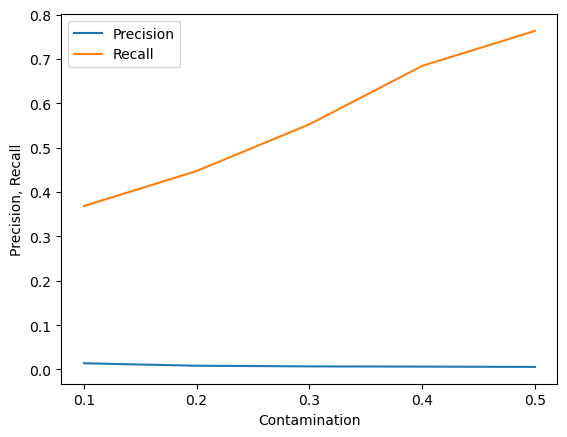

In [30]:
fig, ax = plt.subplots()
ax.plot(contamination_list, precision_list_lof, label='Precision')
ax.plot(contamination_list, recall_list_lof, label='Recall')
ax.legend()
plt.xticks(contamination_list)
ax.set_xlabel('Contamination')
ax.set_ylabel('Precision, Recall')
plt.show()

The Recall value increases with `contamination` as the more values we assign to be outliers the more we are going to find that are actually outliers. At the same time, Precision decreases because we will have more false positives.

In a real world scenario we would need more information about the cost of flagging a transaction as fraudulent to better determine the optimal point between Recall and Precision.

**Question 8:**

Although the valid range of `contamination` parameter is (0.0, 0.5] so we can flag up to half of observations as outliers, it usually doesn't make sense to flag half the observations as outliers, since outliers are very rare.  Based on your answer in question 4 that shows that in this case, the fraudulent transactions are indeed rare, let's check `contimation` only up to 0.1 (we will flag maximum 10% of transactions as fraudulent).
  - Try passing different values to the parameter `contamination` of LocalOutlierFactor in range (0.0, 0.1].
  - Plot the `contamination` parameter on the X axis and both `precision` and `recall` on the Y axis of the same graph.
  - Plot on the same graph a vertical line for contamination (% of transactions flagged as fraudulent) that was found by LocalOutlierFactor with default parameters (question 5).
  - Would you say that the `contamination` chosen by default is a good choice?
  - If you would go with a higher `contamination` value, what value would you choose and why?
  - If you would go with a lower `contamination` value, what value would you choose and why?

In [31]:
contamination_list = np.arange(0.01, 0.11, 0.01)
recall_list_lof = []
precision_list_lof = []

for contamination in contamination_list:
    lof = LocalOutlierFactor(contamination=contamination)
    y_pred = lof.fit_predict(scaled_X)
    
    # Transform y_pred so it matches y_true
    y_pred[y_pred ==  1] = 0
    y_pred[y_pred == -1] = 1

    precision_list_lof.append(precision_score(y_true, y_pred))
    recall_list_lof.append(recall_score(y_true, y_pred))

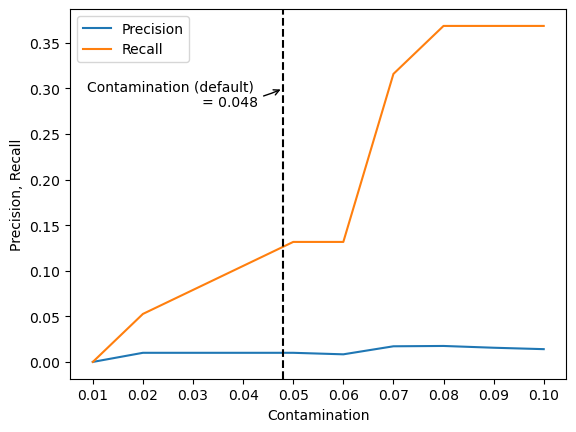

In [32]:
# PLots
fig, ax = plt.subplots()
ax.plot(contamination_list, precision_list_lof, label='Precision')
ax.plot(contamination_list, recall_list_lof, label='Recall')
ax.axvline(outliers_ratio, color='k', linestyle='--')

# Details
ax.legend()
plt.xticks(contamination_list)
ax.set_xlabel('Contamination')
ax.set_ylabel('Precision, Recall')

# Text
# FancyArrowPatch
plt.annotate(f'Contamination (default) \n= {outliers_ratio}',
             xy=(outliers_ratio, 0.3), 
             xytext=(outliers_ratio-0.005, 0.28),
             arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=0.2'},
             horizontalalignment='right')

plt.show()

As can be seen from the graph the contamination chosen does not maximize Recall, so choosing this value can result in fraudulent cases not being detected. Optimizing for Recall we have that at contamination = 0.08 the Recall curve stabilizes, thus I would choose this value.

**Question 9:** Repeat questions 5-8 using `sklearn.ensemble.IsolationForest`.

**Q5**

In [33]:
# IF
random_state = 765
iso_forest = IsolationForest(random_state=random_state)
outlier_scores_if = iso_forest.fit_predict(scaled_X)

In [34]:
outliers_if = (outlier_scores_if == -1)
print(f'Number of Outliers - IF = {outliers_if.sum()}')

Number of Outliers - IF = 382


In [35]:
inliers_if = (outlier_scores_if == 1)
outliers_ratio_if = outliers_if.sum() / len(outlier_scores_if)
print(f'Fraudulent Transaction Percentage - with IF = {outliers_ratio_if*100:.2f}%')

Fraudulent Transaction Percentage - with IF = 3.82%


**Q6**

In [36]:
y_true = y.values
y_pred_if = outlier_scores_if

In [37]:
(y_true == 0).sum()

9962

In [38]:
y_true.min(), y_pred_if.min()

(0, -1)

In [39]:
y_pred_if[y_pred_if ==  1] = 0
y_pred_if[y_pred_if == -1] = 1

In [40]:
# Check
y_pred_if[y_pred_if < 0], y_pred_if[y_pred_if == 0]

(array([], dtype=int32), array([0, 0, 0, ..., 0, 0, 0]))

In [41]:
# Check
(y_pred_if == 1).sum()

382

In [42]:
# Check
(y_true == 1).sum()

38

In [43]:
confusion_matrix(y_true, y_pred_if)

array([[9617,  345],
       [   1,   37]], dtype=int64)

In [44]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_if).ravel()
tn, fp, fn, tp

(9617, 345, 1, 37)

In [45]:
print(classification_report(y_true, y_pred_if))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      9962
           1       0.10      0.97      0.18        38

    accuracy                           0.97     10000
   macro avg       0.55      0.97      0.58     10000
weighted avg       1.00      0.97      0.98     10000



In [46]:
print(f'Fraudulent Transaction Percentage - with IF (default) = {(tp/(y_pred_if == 1).sum())*100:.2f}%')

Fraudulent Transaction Percentage - with IF (default) = 9.69%


With IF we get `9.69%` of the predicted fraudulent transactions versus `0.38%`  from randomly selecting them and `1.04%` with LOF. It is a much better result.

**Q7**

In [47]:
contamination_list = np.arange(0.1, 0.5, 0.1) 
recall_list_if = []
precision_list_if = []

for contamination in contamination_list:
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    y_pred = iso_forest.fit_predict(scaled_X)
    
    # Transform y_pred so it matches y_true
    y_pred[y_pred ==  1] = 0
    y_pred[y_pred == -1] = 1

    precision_list_if.append(precision_score(y_true, y_pred))
    recall_list_if.append(recall_score(y_true, y_pred))

C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


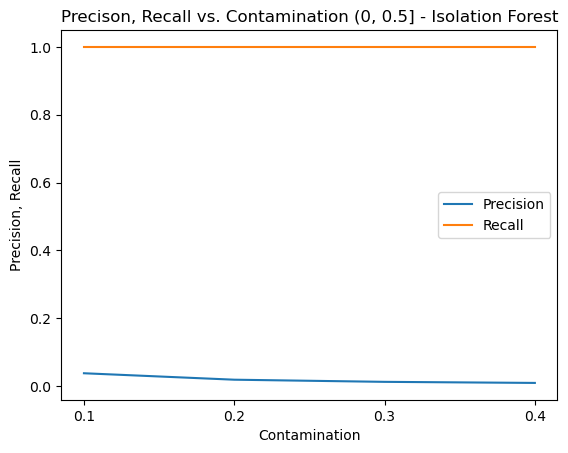

In [48]:
fig, ax = plt.subplots()
ax.plot(contamination_list, precision_list_if, label='Precision')
ax.plot(contamination_list, recall_list_if, label='Recall')
ax.legend()
plt.xticks(contamination_list)
ax.set_xlabel('Contamination')
ax.set_ylabel('Precision, Recall')
plt.title('Precison, Recall vs. Contamination (0, 0.5] - Isolation Forest')
plt.show()

The Recall has a value of 1 for all the contamination levels. This suggests that we should look at what happens before contamination = 0.1 more in depth.

**Q8**

In [49]:
contamination_list = np.arange(0.01, 0.11, 0.01)
recall_list_if = []
precision_list_if = []

for contamination in contamination_list:
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    y_pred = iso_forest.fit_predict(scaled_X)
    
    # Transform y_pred so it matches y_true
    y_pred[y_pred ==  1] = 0
    y_pred[y_pred == -1] = 1

    precision_list_if.append(precision_score(y_true, y_pred))
    recall_list_if.append(recall_score(y_true, y_pred))

C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.w

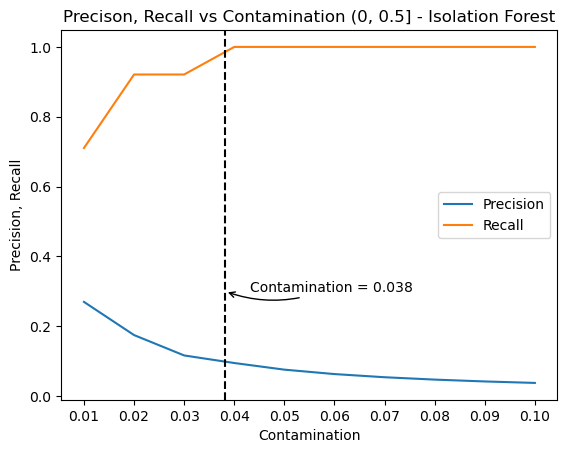

In [50]:
# PLots
fig, ax = plt.subplots()
ax.plot(contamination_list, precision_list_if, label='Precision')
ax.plot(contamination_list, recall_list_if, label='Recall')
ax.axvline(outliers_ratio_if, color='k', linestyle='--')

# Details
ax.legend()
plt.xticks(contamination_list)
ax.set_xlabel('Contamination')
ax.set_ylabel('Precision, Recall')

# Text
# FancyArrowPatch
plt.annotate(f'Contamination = {outliers_ratio_if:.3f}',
             xy=(outliers_ratio_if, 0.3), 
             xytext=(outliers_ratio_if+0.005, 0.3),
             arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=-0.2'},
             horizontalalignment='left')

plt.title('Precison, Recall vs Contamination (0, 0.5] - Isolation Forest')

plt.show()

As can be seen from the graph the Recall value quickly rises to values close to 1. The opposite effect happens with the Precision, as it decreases its level in a smoother way. The default value does a decent job although we can do better if the primary purpose would be to optimize Recall. Again, this depends on the business costs.

**Question 10:** 
- Plot contamination, precision and recall both for LOF and IF on the same graph for contaminations in range (0, 0.1].  **Tip:** use different colors for precision and recall, and different line styles to differentiate between LOF and IF.
- What algorithm gives us consistently better results?
- What algorithm and what contamination value would you choose and why? If you are not sure, give a few options.

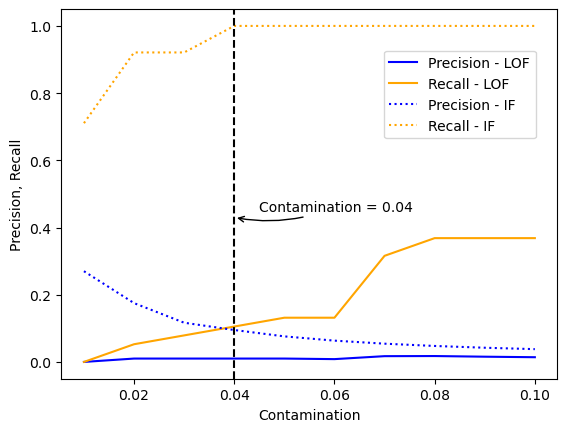

In [51]:
fig, ax = plt.subplots()

ax.plot(contamination_list, precision_list_lof, c='blue',    linestyle='solid' , label='Precision - LOF')
ax.plot(contamination_list, recall_list_lof,    c='orange',  linestyle='solid', label='Recall - LOF')
ax.plot(contamination_list, precision_list_if,  c='blue',    linestyle='dotted',  label='Precision - IF')
ax.plot(contamination_list, recall_list_if,     c='orange',  linestyle='dotted',  label='Recall - IF')

ax.axvline(0.04, color='k', linestyle='--')

plt.annotate(f'Contamination = 0.04',
             xy=(0.04, 0.43), 
             xytext=(0.04+0.005, 0.45),
             arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=-0.15'},
             horizontalalignment='left')

plt.legend(loc=(0.65,0.65))
ax.set_xlabel('Contamination')
ax.set_ylabel('Precision, Recall')

plt.show()

From the graph we can see the better performance of the IF algorithm in terms of Recall and Precision. It also gives us less variability in terms of Recall.

The ideal value would optimize Recall for IF, that is, `contamination = 0.04`. This gives us the best Recall and a decent Precision.